# Importing

In [8]:
import pandas as pd 
import numpy as np
import geopandas as gpd
import fiona
import os
import zipfile
from folium import Map, CircleMarker, Vega, Popup, Marker, PolyLine, Icon, Choropleth, LayerControl
from folium.plugins import MarkerCluster, HeatMap, BeautifyIcon
import shapely
from ipywidgets import interact
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa 

# extracting bikes df

In [2]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
class Databases:
    def __init__(self, csv, anva, smm, metro):
        self.csv = csv
        self.anva = anva 
        self.smm = smm
        self.metro = metro

    def extract_csv(self):
        file = pd.read_csv(f'data/bike_loans/{self.csv}', sep=';')
        file['Fecha_Prestamo'] = pd.to_datetime(file['Fecha_Prestamo'])
        file['Fecha_Devolucion'] = pd.to_datetime(file['Fecha_Devolucion'])
        return file
        
    
    def extract_anva(self):
        bus_routes_AMVA = gpd.GeoDataFrame()
        for root, dirs, files in os.walk(f'data/bus_routes/medellin_bus_routes/{self.anva}'):
            for file in files:
                path = os.path.join(root, file)
                df = gpd.read_file(path, driver='KML')
                bus_routes_AMVA = gpd.GeoDataFrame(pd.concat([bus_routes_AMVA, df], ignore_index=True))
        return bus_routes_AMVA
    
    def extract_smm(self):
        smm_bus_routes = gpd.GeoDataFrame()
        for root, dirs, files in os.walk(f'data/bus_routes/medellin_bus_routes/{self.smm}'):
            for file in files:
                path = os.path.join(root, file)
                df = gpd.read_file(path, driver='KML')
                smm_bus_routes = gpd.GeoDataFrame(pd.concat([smm_bus_routes, df], ignore_index=True))
        return smm_bus_routes
    
    def extract_metro(self):
        metro_routes = gpd.GeoDataFrame()
        for root, dirs, files in os.walk(f'data/medellin_metro/{self.metro}'):
            for file in files:
                path = os.path.join(root, file)
                print(path)
                if path.endswith('.kmz'):
                    kmz = zipfile.ZipFile(path, 'r')
                    kml = kmz.open('doc.kml', 'r')
                    df = gpd.read_file(kml, driver='KML')
                    metro_routes = gpd.GeoDataFrame(pd.concat([metro_routes, df], ignore_index=True))
        return metro_routes


In [3]:
databases = Databases('bike_loans.csv','Kml Ruta AMVA','kml Ruta SMM','medellin_metro_stations')

In [4]:
bikes = databases.extract_csv()

In [5]:
bikes.dtypes

Id_Historico_Prestamo               int64
Id_Usuario                          int64
Id_Tag_Bicicleta                   object
Fecha_Prestamo             datetime64[ns]
Fecha_Devolucion           datetime64[ns]
Id_Aparcamiento_Origen              int64
Posicion_Origen                     int64
Id_Aparcamiento_Destino           float64
Posicion_Destino                  float64
Importe                           float64
DescripcionImporte                float64
operario                           object
Num_Bici_Hist                     float64
dtype: object

# Prime analysis

We can start our analysis with general description of the dataset. <br>
**NB**: In our dataset we are dealing with all categorical features or timeseries: there is no need to run ```describe()``` 

- Id_Tag_Bicicleta : column regarding unique id of each bicycle 
***let's have a look on how many times the same bike is used (how many times the unique id is present in the df)**

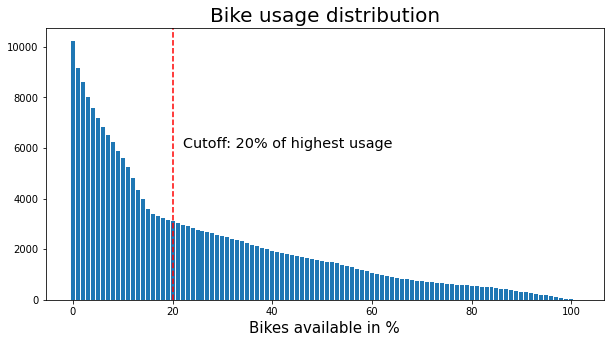

In [12]:
plt.figure(figsize=(10,5))
plt.title('Bike usage distribution', size=20)
counts = bikes.Id_Tag_Bicicleta.value_counts()[::66]
y_pos = np.arange(len(counts))
plt.bar(y_pos, counts)
plt.xlabel('Bikes available in %', size=15)
plt.text(x=22, y=6000, s=f'Cutoff: 20% of highest usage', size='x-large')
plt.axvline(20, color='r', linestyle='--')

plt.show()

As we can see there is a clear cutoff in the 20% of the distribuition. That's can also aimed to the different time of putting that bike on the streets.

In our dataset we have information about the bike itself, the station of arrival and departures and the costumer. To characterized all this information we have also 2 time series: ```Fecha_Prestamo``` & ```Fecha_Devolucion``` 

<br>
Thank to these we can have an idea of the time in which the bike are more used, which routes are more popular during a certain range of time and also how the data collected has changed during the years, according maybe to the change in habits of the population. 

In [19]:
# Extracting just the hour: 
bikes['hour_init']= bikes['Fecha_Prestamo'].dt.hour
bikes['hour_end']=bikes['Fecha_Devolucion'].dt.hour
bikes.head(5)

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Importe,DescripcionImporte,operario,Num_Bici_Hist,hour_init,hour_end
0,6501462,18701,000017B00743,2017-06-21 14:22:11,2017-06-21 14:38:29,8,1,43.0,1.0,0.0,NaN,jhon.castano,929.0,14,14
1,6501318,41811,000017AFF83C,2017-06-21 14:07:18,2017-06-21 14:39:06,56,6,54.0,NaN,0.0,NaN,monitor,1612.0,14,14
2,6501489,96620,000017AFFB6F,2017-06-21 14:25:11,2017-06-21 14:39:07,36,25,9.0,13.0,0.0,NaN,NaN,1679.0,14,14
3,6501001,16055,0000182A3B7B,2017-06-21 13:35:52,2017-06-21 14:39:22,8,1,9.0,6.0,0.0,NaN,NaN,1076.0,13,14
4,6501421,6431,000017AFE810,2017-06-21 14:17:56,2017-06-21 14:39:26,56,14,54.0,NaN,0.0,NaN,monitor,1176.0,14,14


The highest usage of bikes is at 17 and 7


/Users/olgacravesana/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


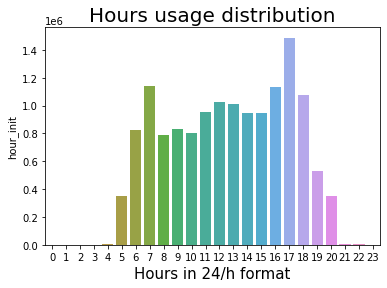

In [34]:
hours = pd.DataFrame(bikes.hour_init.value_counts())
sns.barplot(hours.index,hours.hour_init)
plt.title('Hours usage distribution', size=20)
plt.xlabel('Hours in 24/h format', size=15)
print(f'The highest usage of bikes is at 17 and 7')

As we can see our distribution is not normal distributed: we have a significant **higher affluence** are the ones right after work/university (17,18,16) or the ones right before (7).

We can so deduct that the bicycle are more often used by students or worker, as a real way of transportation. 
If this is true we will have some routes that are more used, some station that probably have a bigger affluences of both take and drop off. 

Let's have a look at the routes:

In [36]:
bikes['routes'] = bikes.apply(lambda x: (x.Id_Aparcamiento_Origen, int(x.Id_Aparcamiento_Destino)), axis=1)

ValueError: cannot convert float NaN to integer

In [ ]:
counts = bike_df.routes.value_counts()
x = counts.keys()
y = list(counts)
plt.figure(figsize=(20,10))
sns.barplot(x=x, y=y)
plt.title('Most used bike routes', size=15)
plt.xticks(rotation=90, size=5)
plt.show()